In [1]:
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import stats

In [2]:
# Read from csv 
drug_related_deaths_df = pd.read_csv('../Datasets/Accidental_Drug_Related_Deaths_2012-2018.csv')

### Data Cleanup

In [3]:
# Removing unnecessary columns
narrowed_df = drug_related_deaths_df.loc[:,['ID','Date','Age','Sex','Race','DeathCity','DeathCityGeo','COD','Heroin','Cocaine','Fentanyl','FentanylAnalogue','Oxycodone','Oxymorphone','Ethanol','Hydrocodone','Benzodiazepine','Methadone','Amphet','Tramad','Morphine_NotHeroin','Hydromorphone','Other','OpiateNOS','AnyOpioid']]

# Drop records without Age, Sex and Race entry
narrowed_df = narrowed_df.dropna(subset=['Age', 'Sex','Race'], how='all')

# Fill NaN values by N
narrowed_df.update(narrowed_df[['Heroin','Cocaine','Fentanyl','FentanylAnalogue','Oxycodone','Oxymorphone','Ethanol','Hydrocodone','Benzodiazepine','Methadone','Amphet','Tramad','Morphine_NotHeroin','Hydromorphone','Other','OpiateNOS','AnyOpioid']].fillna('N'))

# Convert date column to Datetime object
narrowed_df['Date'] = pd.to_datetime(narrowed_df['Date'])
narrowed_df

narrowed_df.to_csv('../Datasets/Reduced_DataSet.csv')

In [4]:
narrowed_df.head()

,ID,Date,Age,Sex,Race,DeathCity,DeathCityGeo,COD,Heroin,Cocaine,...,Hydrocodone,Benzodiazepine,Methadone,Amphet,Tramad,Morphine_NotHeroin,Hydromorphone,Other,OpiateNOS,AnyOpioid
1,13-0102,2013-03-21,48.0,Male,Black,NORWALK,"Norwalk, CT\n(41.11805, -73.412906)",Cocaine Intoxication,N,Y,...,N,N,N,N,N,N,N,N,N,N
2,16-0165,2016-03-13,30.0,Female,White,DANBURY,"Danbury, CT\n(41.393666, -73.451539)",Acute Heroin and Cocaine Intoxication,Y,Y,...,N,N,N,N,N,N,N,N,N,Y
3,16-0208,2016-03-31,23.0,Male,White,GREENWICH,"Greenwich, CT\n(41.026526, -73.628549)",Acute Fentanyl and Morphine Intoxication,Y,N,...,N,N,N,N,N,N,N,N,N,Y
4,13-0052,2013-02-13,22.0,Male,"Asian, Other",GREENWICH,"Greenwich, CT\n(41.026526, -73.628549)",Fentanyl Intoxication,N,N,...,N,N,N,N,N,N,N,N,N,N
5,14-0277,2014-06-29,23.0,Male,White,BRISTOL,"BRISTOL, CT\n(41.673037, -72.945791)",Heroin Intoxication,Y,N,...,N,N,N,N,N,N,N,N,N,N


### Kensuke - Top 3 Drugs Contributing to Accidental Death

In [5]:
narrowed2_df = narrowed_df.copy()
narrowed3_df = narrowed_df.copy() 

In [6]:
drugnames = list(narrowed2_df.columns[9:23])
# Declaring an empty list
totalvalue = []

In [7]:
# This loop will pick the drug column name and iterates through dat frame. 
# The summation counter increments if the value of each cell is not N. 
for drug in drugnames:
    counter = 0
    for index , value in narrowed2_df.iterrows():
        if(narrowed2_df.at[index,drug] != 'N'):
            counter = counter + 1
    totalvalue.append(counter)

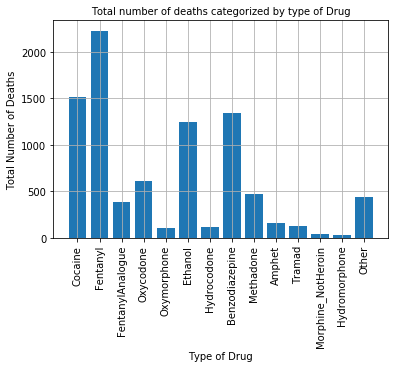

In [8]:
# Plotting the results on a scatter plot. 
plt.bar(drugnames,totalvalue)
plt.xlabel('Type of Drug',fontsize = 10)
plt.ylabel('Total Number of Deaths',fontsize = 10)
plt.title('Total number of deaths categorized by type of Drug', fontsize = 10)
plt.grid(True)
plt.xticks(drugnames, drugnames, rotation='vertical')
plt.savefig('../Accidental-Drug-Related-Deaths/Images/Deaths_Per_Drug_Type.png')

### Prerak - Drug Related Deaths - Seasonal Impact

In [105]:
# Get count of deaths in each month
narrowed_df.index = pd.to_datetime(narrowed_df['Date'],format='%m/%d/%y %I:%M%p')
deaths_by_year_month_df = narrowed_df.groupby(by=[narrowed_df.index.year,narrowed_df.index.month]).agg({'ID':'count'})

In [106]:
# Create new dataframe with year,month and day concatenated
deaths_per_months_df = pd.DataFrame(columns=['Month', 'Deaths Per Month'])
for index, row in deaths_by_year_month_df.iterrows():
    year = int(index[0])
    month = int(index[1])
    day = 1
    count = row[0]
    
    converted_date = datetime(year,month,day)
    deaths_per_months_df = deaths_per_months_df.append({'Month': converted_date, 'Deaths Per Month': count}, ignore_index=True)  

In [107]:
# Set index as month to plot Deaths per month chart
deaths_per_months_df.set_index('Month', inplace=True)
deaths_per_months_df.head()

,Deaths Per Month
Month,
2012-01-01,31
2012-02-01,27
2012-03-01,24
2012-04-01,30
2012-05-01,28


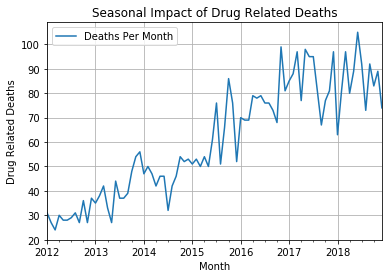

In [108]:
start_date = datetime(2012,1,1)
end_date = datetime(2018,12,1)

deaths_per_months_df[(start_date <= deaths_per_months_df.index) & (deaths_per_months_df.index <= end_date)].plot(grid='on')
plt.title('Seasonal Impact of Drug Related Deaths')
plt.ylabel('Drug Related Deaths')
plt.savefig('../Accidental-Drug-Related-Deaths/Images/Deaths_Per_season.png')

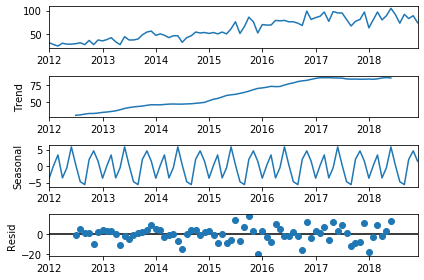

In [133]:
decomposition = sm.tsa.seasonal_decompose(deaths_per_months_df,model='additive')
fig = decomposition.plot()
plt.savefig('../Accidental-Drug-Related-Deaths/Images/Deaths_Per_season_time_series.png')

### Loretta - Relation of age, gender and race on drug related deaths

In [10]:
gender_df = narrowed_df.loc[narrowed_df['Sex'].isin(['Female','Male'])]
grouped_gender_df = gender_df.groupby(["Sex"]).agg({'ID':'count'})
grouped_gender_df.head()

,ID
Sex,
Female,1325
Male,3773


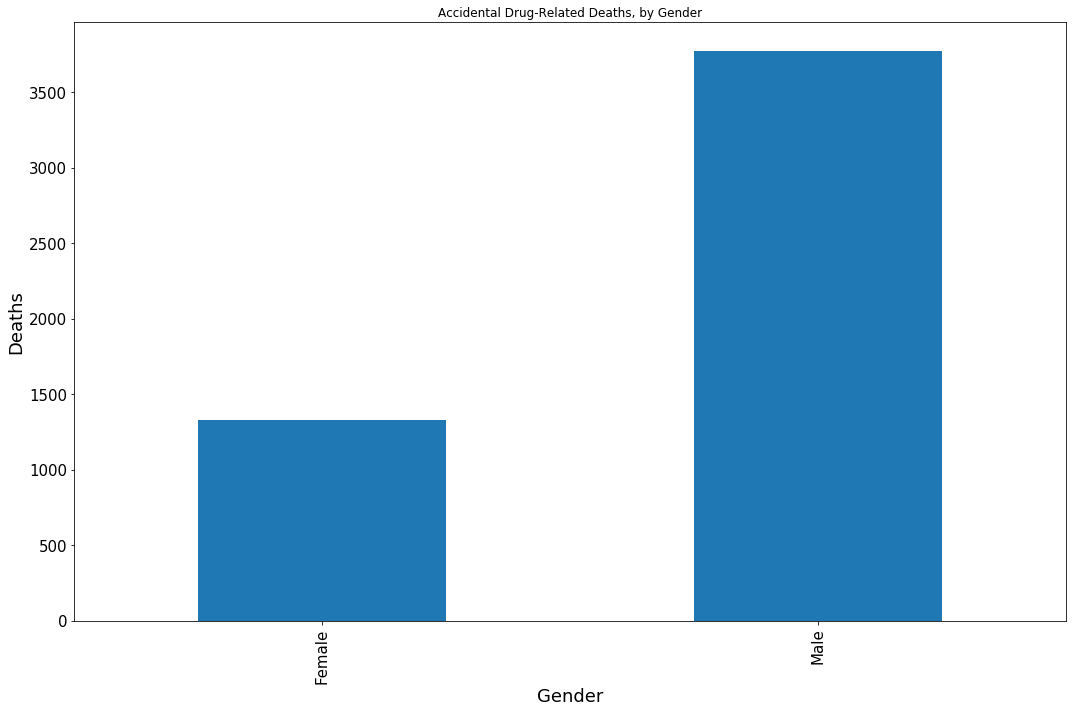

In [11]:
# Graph of Accidental Drug-related Deaths by Sex
ax = grouped_gender_df.plot(kind='bar', title ="Accidental Drug-Related Deaths, by Gender", figsize=(15, 10), legend=False, fontsize=15)
plt.xlabel("Gender", fontsize=18)
plt.ylabel("Deaths", fontsize=18)
plt.tight_layout()
plt.savefig('../Accidental-Drug-Related-Deaths/Images/Deaths_Per_Gender.png')
plt.show()

In [112]:
# Accidental Drug-related deaths by Race
grouped_race_df = narrowed_df.groupby(["Race"]).agg({'ID':'count'})
grouped_race_df.head(15)

,ID
Race,
Asian Indian,14
"Asian, Other",18
Black,433
Chinese,2
Hawaiian,1
"Hispanic, Black",24
"Hispanic, White",561
"Native American, Other",1
Other,11


In [12]:
# Combine some of the Race values

narrowed_df["Race"].replace({"Asian Indian": "Asian", "Asian, Other": "Asian", "Chinese":"Asian","Hawaiian":"Other","Unknown": "Other", "Native American, Other": "Native American", "Hispanic, Black": "Hispanic", "Hispanic, White": "Hispanic"}, inplace=True)

grouped_race_df = narrowed_df.groupby(["Race"]).agg({'ID':'count'})

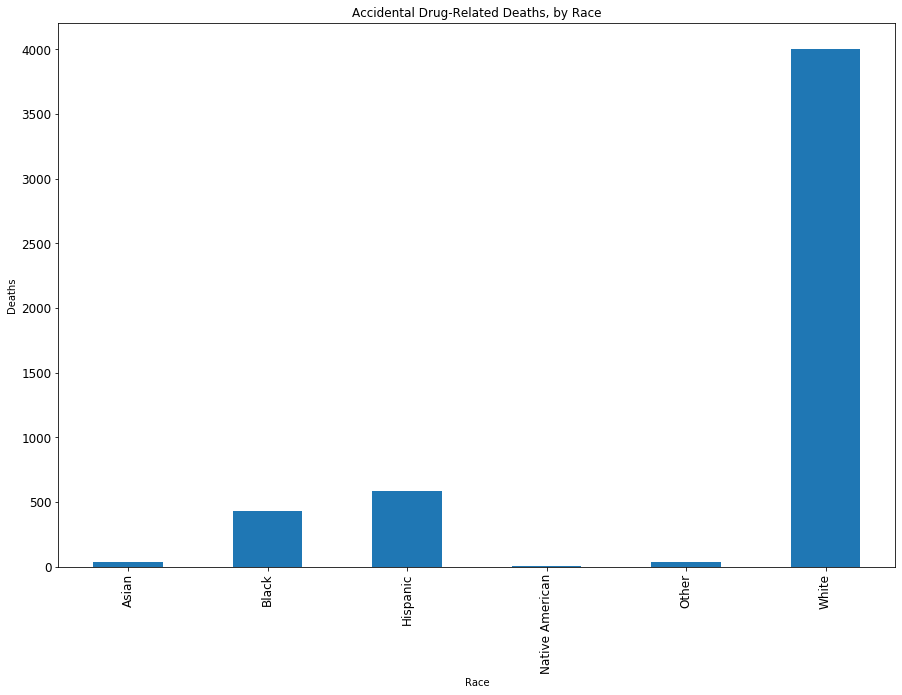

In [13]:
# Bar graph of Accidental Drug-related Deaths by Race
ax = grouped_race_df.plot(kind='bar', title ="Accidental Drug-Related Deaths, by Race", figsize=(15, 10), legend=False, fontsize=12)
plt.xlabel("Race")
plt.ylabel("Deaths")
plt.savefig('../Accidental-Drug-Related-Deaths/Images/Deaths_Per_Race.png')
plt.show()

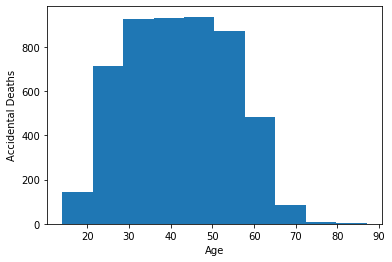

In [115]:
# Histogram of Accidental Deaths by Age
Agedeaths = narrowed_df["Age"]

plt.hist(Agedeaths)
plt.xlabel("Age")
plt.ylabel("Accidental Deaths")
plt.show()

In [116]:
# Create age groups (0-under 25, 25-40, 41-65, over 65)
bins = [-1, 25, 41, 66, 199]
AgeGroups = ['Under 25','25-40','41-65','over 65']

#Place data series into new column in dataframe
narrowed_df["Age Group"] = pd.cut(narrowed_df["Age"], bins, labels=AgeGroups)
narrowed_df.head()

grouped_AgeGroup_df = narrowed_df.groupby(["Age Group"]).agg({'ID':'count'})
grouped_AgeGroup_df.head(10)

,ID
Age Group,
Under 25,503
25-40,2006
41-65,2522
over 65,71


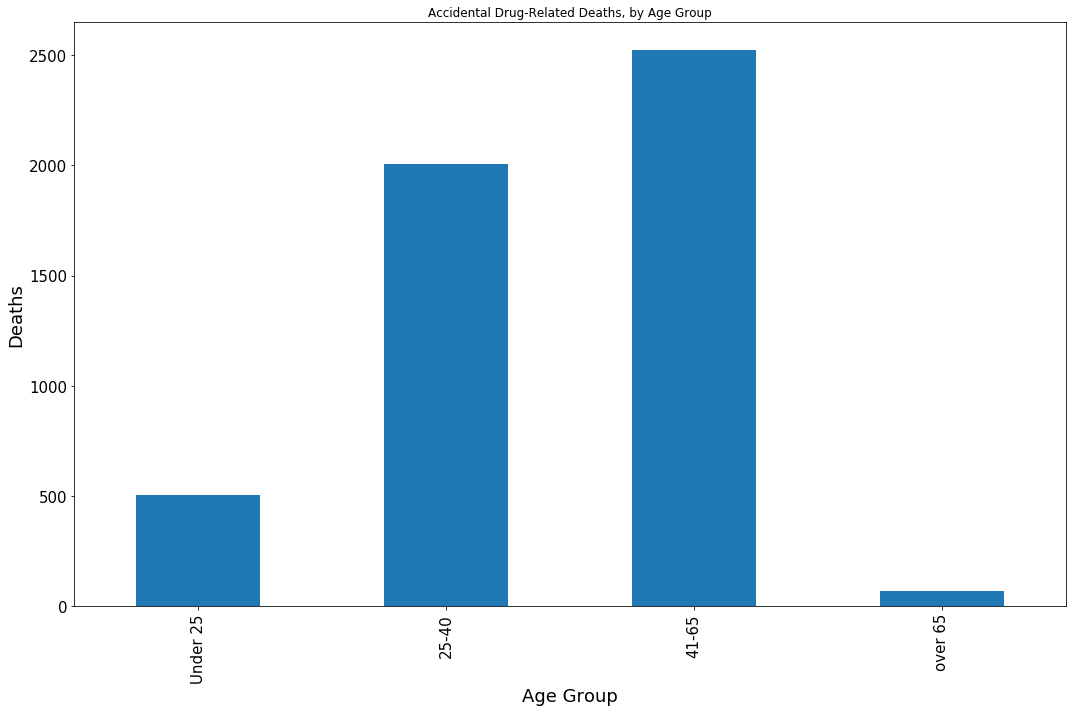

In [117]:
# Accidental Drug-related deaths by Age Groups
ax = grouped_AgeGroup_df.plot(kind='bar', title ="Accidental Drug-Related Deaths, by Age Group", figsize=(15, 10), legend=False, fontsize=15)
plt.xlabel("Age Group", fontsize=18)
plt.ylabel("Deaths", fontsize=18)
plt.tight_layout()
plt.show()

### Daniel - Drugs Related Deaths by City

In [120]:
accidental_drug_related = "../Datasets/Accidental_Drug_Related_Deaths_2012-2018.csv"

#Read csv data and analyze results 
accidental_drug_related = pd.read_csv(accidental_drug_related)
accidental_drug_related.head()

,ID,Date,DateType,Age,Sex,Race,ResidenceCity,ResidenceCounty,ResidenceState,DeathCity,...,Tramad,Morphine_NotHeroin,Hydromorphone,Other,OpiateNOS,AnyOpioid,MannerofDeath,DeathCityGeo,ResidenceCityGeo,InjuryCityGeo
0,14-0273,06/28/2014 12:00:00 AM,DateReported,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Accident,"CT\n(41.575155, -72.738288)","CT\n(41.575155, -72.738288)","CT\n(41.575155, -72.738288)"
1,13-0102,03/21/2013 12:00:00 AM,DateofDeath,48.0,Male,Black,NORWALK,NaN,NaN,NORWALK,...,NaN,NaN,NaN,NaN,NaN,NaN,Accident,"Norwalk, CT\n(41.11805, -73.412906)","NORWALK, CT\n(41.11805, -73.412906)","CT\n(41.575155, -72.738288)"
2,16-0165,03/13/2016 12:00:00 AM,DateofDeath,30.0,Female,White,SANDY HOOK,FAIRFIELD,CT,DANBURY,...,NaN,NaN,NaN,NaN,NaN,Y,Accident,"Danbury, CT\n(41.393666, -73.451539)","SANDY HOOK, CT\n(41.419998, -73.282501)",NaN
3,16-0208,03/31/2016 12:00:00 AM,DateofDeath,23.0,Male,White,RYE,WESTCHESTER,NY,GREENWICH,...,NaN,NaN,NaN,NaN,NaN,Y,Accident,"Greenwich, CT\n(41.026526, -73.628549)",NaN,NaN
4,13-0052,02/13/2013 12:00:00 AM,DateofDeath,22.0,Male,"Asian, Other",FLUSHING,QUEENS,NaN,GREENWICH,...,NaN,NaN,NaN,NaN,NaN,NaN,Accident,"Greenwich, CT\n(41.026526, -73.628549)",NaN,"CT\n(41.575155, -72.738288)"


In [121]:
#Drop Columns that are not needed 
accidental_drug_related.drop(['ID','Date','DateType','Age','Sex','Race','MannerofDeath',
'DeathCityGeo','ResidenceCityGeo','InjuryCityGeo','DescriptionofInjury','InjuryPlace','InjuryCity',
'InjuryCounty','InjuryState','COD','OtherSignifican','OpiateNOS','AnyOpioid','MannerofDeath',
'DeathCityGeo','ResidenceCityGeo','InjuryCityGeo','Location','LocationifOther'], axis=1, inplace=True)

#Check to see what column has the most information (DeathCity)
accidental_drug_related.isnull().sum()

ResidenceCity          173
ResidenceCounty        797
ResidenceState        1549
DeathCity                5
DeathCounty           1100
Heroin                2576
Cocaine               3584
Fentanyl              2873
FentanylAnalogue      4716
Oxycodone             4498
Oxymorphone           4997
Ethanol               3858
Hydrocodone           4987
Benzodiazepine        3762
Methadone             4631
Amphet                4946
Tramad                4975
Morphine_NotHeroin    5063
Hydromorphone         5080
Other                 4670
dtype: int64

In [122]:
#Fill in missing information to be a 0
accidental_drug_related.shape

accidental_drug_related.dropna(subset=['DeathCity'], how='any').shape

new_accidental_drug_related = accidental_drug_related.fillna(0)
new_accidental_drug_related.head()

,ResidenceCity,ResidenceCounty,ResidenceState,DeathCity,DeathCounty,Heroin,Cocaine,Fentanyl,FentanylAnalogue,Oxycodone,Oxymorphone,Ethanol,Hydrocodone,Benzodiazepine,Methadone,Amphet,Tramad,Morphine_NotHeroin,Hydromorphone,Other
0,0,0,0,0,0,0,0,Y,0,0,0,0,Y,Y,0,0,0,0,0,0
1,NORWALK,0,0,NORWALK,FAIRFIELD,0,Y,0,0,0,0,0,0,0,0,0,0,0,0,0
2,SANDY HOOK,FAIRFIELD,CT,DANBURY,0,Y,Y,0,0,0,0,0,0,0,0,0,0,0,0,0
3,RYE,WESTCHESTER,NY,GREENWICH,0,Y,0,Y,0,0,0,0,0,0,0,0,0,0,0,0
4,FLUSHING,QUEENS,0,GREENWICH,FAIRFIELD,0,0,Y,0,0,0,0,0,0,0,0,0,0,0,0


In [123]:
#Replace 'Y' for a 1 in order to use values for extracting information
d_count = new_accidental_drug_related.replace({'Y':1})
d_count.head()

,ResidenceCity,ResidenceCounty,ResidenceState,DeathCity,DeathCounty,Heroin,Cocaine,Fentanyl,FentanylAnalogue,Oxycodone,Oxymorphone,Ethanol,Hydrocodone,Benzodiazepine,Methadone,Amphet,Tramad,Morphine_NotHeroin,Hydromorphone,Other
0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0
1,NORWALK,0,0,NORWALK,FAIRFIELD,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,SANDY HOOK,FAIRFIELD,CT,DANBURY,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,RYE,WESTCHESTER,NY,GREENWICH,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,FLUSHING,QUEENS,0,GREENWICH,FAIRFIELD,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [124]:
#Group and add values
drug_count = d_count.groupby('DeathCity').sum()
drug_count.head()

,Heroin,Cocaine,FentanylAnalogue,Oxycodone,Oxymorphone,Ethanol,Hydrocodone,Benzodiazepine,Methadone,Amphet,Tramad,Hydromorphone
DeathCity,,,,,,,,,,,,
0,0,2,0,0,0,0,1,1,0,0,0,0
06340,0,1,0,0,0,1,0,0,0,0,0,0
AMSTON,1,0,0,0,0,0,0,0,0,0,0,0
ANDOVER,1,0,0,2,0,1,0,0,0,0,0,0
ANSONIA,6,4,1,8,1,5,0,8,5,1,0,0


In [125]:
#Return index
drug_count.index.name = None 
drug_count.index.name = 'DeathCity'
drug_count.reset_index(inplace=True)
drug_count.head()

,DeathCity,Heroin,Cocaine,FentanylAnalogue,Oxycodone,Oxymorphone,Ethanol,Hydrocodone,Benzodiazepine,Methadone,Amphet,Tramad,Hydromorphone
0,0,0,2,0,0,0,0,1,1,0,0,0,0
1,06340,0,1,0,0,0,1,0,0,0,0,0,0
2,AMSTON,1,0,0,0,0,0,0,0,0,0,0,0
3,ANDOVER,1,0,0,2,0,1,0,0,0,0,0,0
4,ANSONIA,6,4,1,8,1,5,0,8,5,1,0,0


In [126]:
#Create new column with total
drug_count['Total Amount of Drugs'] = drug_count['Heroin'] + drug_count['Cocaine'] + drug_count['FentanylAnalogue'] + drug_count['Oxycodone'] + drug_count['Oxymorphone'] + drug_count['Ethanol'] + drug_count['Hydrocodone'] + drug_count['Benzodiazepine'] + drug_count['Methadone'] + drug_count['Amphet'] + drug_count['Tramad'] + drug_count['Hydromorphone']
drug_count.head()

,DeathCity,Heroin,Cocaine,FentanylAnalogue,Oxycodone,Oxymorphone,Ethanol,Hydrocodone,Benzodiazepine,Methadone,Amphet,Tramad,Hydromorphone,Total Amount of Drugs
0,0,0,2,0,0,0,0,1,1,0,0,0,0,4
1,06340,0,1,0,0,0,1,0,0,0,0,0,0,2
2,AMSTON,1,0,0,0,0,0,0,0,0,0,0,0,1
3,ANDOVER,1,0,0,2,0,1,0,0,0,0,0,0,4
4,ANSONIA,6,4,1,8,1,5,0,8,5,1,0,0,39


In [127]:
#Filter dataframe to only show the top 10 
top = drug_count.nlargest(10,['Total Amount of Drugs'])
top

,DeathCity,Heroin,Cocaine,FentanylAnalogue,Oxycodone,Oxymorphone,Ethanol,Hydrocodone,Benzodiazepine,Methadone,Amphet,Tramad,Hydromorphone,Total Amount of Drugs
78,HARTFORD,280,216,39,35,4,125,5,92,28,14,12,2,852
198,WATERBURY,204,139,40,31,4,89,5,92,46,11,10,2,673
114,NEW HAVEN,183,118,25,39,3,92,6,99,63,9,11,2,650
20,BRIDGEPORT,178,128,22,29,6,99,6,88,48,7,5,0,616
109,NEW BRITAIN,96,59,20,33,4,56,4,56,14,7,5,1,355
96,MERIDEN,75,50,15,12,5,39,3,36,13,6,2,1,257
22,BRISTOL,68,40,12,12,3,30,4,48,14,4,7,0,242
133,NORWICH,73,39,5,14,2,34,6,32,8,5,0,2,220
40,DANBURY,68,32,12,14,2,26,3,33,12,4,6,0,212
115,NEW LONDON,76,37,5,13,2,35,6,20,9,3,4,0,210


In [128]:
#Filter data to only show specific columns
top_d_t = top.loc[:,['DeathCity','Total Amount of Drugs']]
top_d_t

,DeathCity,Total Amount of Drugs
78,HARTFORD,852
198,WATERBURY,673
114,NEW HAVEN,650
20,BRIDGEPORT,616
109,NEW BRITAIN,355
96,MERIDEN,257
22,BRISTOL,242
133,NORWICH,220
40,DANBURY,212
115,NEW LONDON,210


In [129]:
#Groupby DeathCity in order to show the city names in the bar chart
topten = top_d_t.groupby('DeathCity').sum()
newtopten = topten.nlargest(10,['Total Amount of Drugs'])
newtopten

,Total Amount of Drugs
DeathCity,
HARTFORD,852
WATERBURY,673
NEW HAVEN,650
BRIDGEPORT,616
NEW BRITAIN,355
MERIDEN,257
BRISTOL,242
NORWICH,220
DANBURY,212


Text(0, 0.5, 'Number of Deaths')

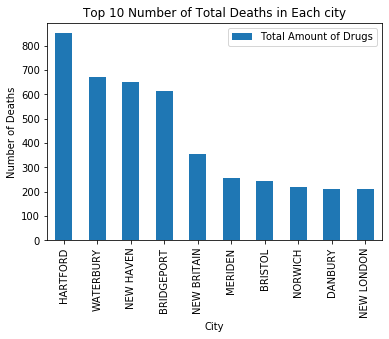

In [130]:
# Generate a bar plot showing number total deaths in the top ten cities
bdd = newtopten.plot.bar(rot='vertical',title='Top 10 Number of Total Deaths in Each city')
bdd.set_xlabel("City")
bdd.set_ylabel("Number of Deaths")

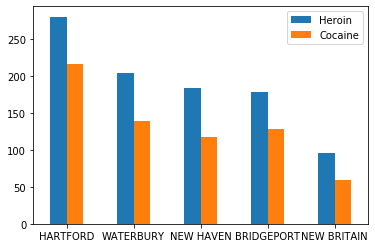

In [131]:
heroin = [280,204,183,178,96]
cocaine = [216,139,118,128,59]
index = ['HARTFORD','WATERBURY','NEW HAVEN','BRIDGEPORT','NEW BRITAIN']
df = pd.DataFrame({'Heroin': heroin,
                'Cocaine': cocaine}, index=index)
ax = df.plot.bar(rot=0)
